In [1]:
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage import morphology
from scipy import ndimage

from deeplate.MMdata import MMData

In [2]:
data_folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20170126/201710126_lowerbound/'
folder = '/scicore/home/nimwegen/witzg/DeepPlateAnalysis/usingsubset6/Analysis_201710126_lowerbound/'

In [3]:
posid = [re.findall('(?<=maskcorrect_)(\d+)(?=\.npy)',f) for f in os.listdir(folder)]
posid = [int(x[0]) for x in posid if len(x)>0]

In [5]:
MMobj = MMData(folder = data_folder)

In [13]:
mask = label(np.load(folder+'maskcorrect_'+str(posid[0])+'.npy'))
all_correlations = np.empty((mask.shape[0],mask.shape[1],len(posid)))
all_masks = np.empty((mask.shape[0],mask.shape[1],len(posid)))
all_weights = np.empty((mask.shape[0],mask.shape[1],len(posid)))

all_planes = np.empty((mask.shape[0],mask.shape[1],3, len(posid)))

for i in range(len(posid)):
    all_masks[:,:,i] = np.load(folder+'maskcorrect_'+str(posid[i])+'.npy')
    all_weights[:,:,i] = np.load(folder+'weightcorrect_'+str(posid[i])+'.npy')
    all_correlations[:,:,i] = np.load(folder+'corr_'+str(posid[i])+'.npy')
    

In [23]:
np.random.randint(1,30,1000).min()

1

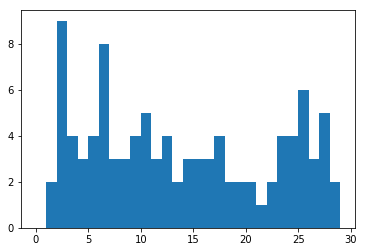

In [20]:
plt.hist(np.random.randint(1,29,100),bins = np.arange(0,30,1))
plt.show()

In [6]:
MMobj.num_planes

[1, 31]

In [ ]:
np.random.randint(1,30,1000).min()
all_planes[:,:,j,i] = MMobj.get_image(frame=0,channel=0,plane=0,position=0, compress = 1):